In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Drive-by-Wire Node Testing

Udacity provided the `dbw_test` node to check the outputs of the DBW node against those from a reference databag, but they did not provide the reference databag. They did however provide a databag that included the required data (and other data) later in the course, so we've used that data here to calibrate the DBW node.

This required some minor mods to the `dbw_test` node to (1) also log the time, which makes it easier to plot the data, and (2) only play the required topics from the rosbag.

### Load Data from `dbw_test` Node

In [3]:
def parse_stamp(x):
    return pd.to_datetime(float(x), unit='s', utc=True)

def read_data(test_folder):
    cmds = ['steer', 'throttle', 'brake']
    csvs = [
        pd.read_csv(
            os.path.join(test_folder, cmd + 's.csv'),
            date_parser = parse_stamp,
            parse_dates = ['time'])
        for cmd in cmds
    ]
    for csv, cmd in zip(csvs, cmds):
        csv['cmd'] = cmd
        csv['t'] = (csv['time'] - csv['time'].min()) \
            .map(lambda x: x.total_seconds())
    data = pd.concat(csvs)
    return data.melt(
        id_vars=['cmd', 't'],
        value_vars=['actual', 'proposed'])

## With Settings for Simulator

After tuning the DBW node for the simulator, the outputs were as follows.

It looks like we are stlightly understeering and underbraking.

As has been noted many times on Slack, the throttle commands required in the simulator are much higher than those on Carla.

In [4]:
data_1 = read_data('dbw_test_1')

In [5]:
data_1[0:10]

,cmd,t,variable,value
0,steer,0.000000,actual,-0.000000
1,steer,0.039943,actual,-0.000000
2,steer,0.060657,actual,-0.000000
3,steer,0.100011,actual,-0.000000
4,steer,0.140248,actual,-0.000000
5,steer,0.160509,actual,-0.504755
6,steer,0.200895,actual,-0.533435
7,steer,0.240220,actual,-0.601215
8,steer,0.260009,actual,-0.658473
9,steer,0.300985,actual,-0.692828


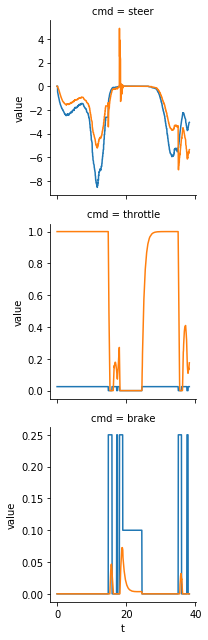

In [6]:
def plot_cmds(data):
    # The brake commands in the reference dataset are percentages,
    # but we're using the torque values. I'm assuming that the documentation
    # http://docs.ros.org/kinetic/api/dbw_mkz_msgs/html/msg/BrakeCmd.html
    # is correct, and the maximum torque is 3250Nm.
    data = data.copy()
    is_brake = (data['cmd'] == 'brake') & (data['variable'] == 'proposed')
    data.loc[is_brake, 'value'] = data[is_brake]['value'] / 3250.0
    
    g = sns.FacetGrid(
        data, row='cmd', hue='variable', sharex=True, sharey=False)
    g = g.map(plt.plot, 't', 'value')
plot_cmds(data_1)

### With Throttle Correction

To correct for the large difference in throttle, we've added a `max_throttle` parameter to the `dbw_node` that is `1` in simulation and `0.025` for Carla.

In [7]:
data_2 = read_data('dbw_test_2')

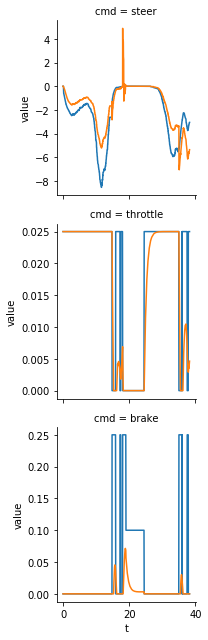

In [8]:
plot_cmds(data_2)

### With Throttle and Brake Correction

I think the braking torques need to be multiplied by 4, possibly because it's being divided between the 4 wheels. Also add an 'all stop' torque to apply the brakes consistently when the vehicle is supposed to be stopped (and is already mostly stopped).

This also includes a fix to the steering so that it will steer at lower speeds; previously it did not steer when the target speed was zero.

In [9]:
data_3 = read_data('dbw_test_3')

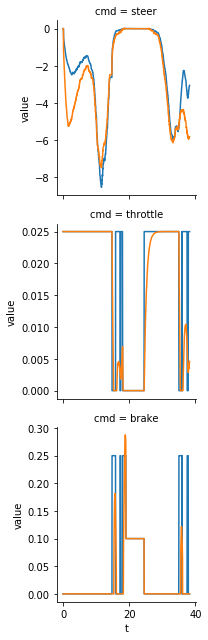

In [10]:
plot_cmds(data_3)